<a href="https://colab.research.google.com/github/avanishkumar1994/Landscape-Detector-Web-App-Render-/blob/master/Intel_Landscape_Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Below code is because of a bug. By default pytorch 1.5 is instaled which results in bug

In [0]:
import torch as torch
if str(torch.__version__)=='1.4.0' :
  print("1.4.0")
else:
  !pip install torch==1.4.0 torchvision==0.5.0

1.4.0


In [0]:
!curl https://course.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   322  100   322    0     0   4236      0 --:--:-- --:--:-- --:--:--  4236
Updating fastai...
Done.


We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models. The Below lines are not python code. It's for jupyter notebook. Called magics. Whenever the notebook initialises, the run

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [0]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

Bascially, the above line will take 64 image at a time to process*

In [0]:
!pip list

1. Firstly, I uploaded a tgz file in /content/data folder. File name: devanagarihandwrittencharacterdataset.tgz

2. Applied the following code : 
path=untar_data('/content/data/devanagarihandwrittencharacterdataset')

3. Moved the untarred folder by drag and drip to /content/data/devanagarihandwrittencharacterdataset folder



The Untar_data command unarchives a tgz file

In [0]:
#path=untar_data('/content/data/intel-image-classification')

path = Path('/content/data/intel-image-classification')


In [0]:
path.ls()

[PosixPath('/content/data/intel-image-classification/train'),
 PosixPath('/content/data/intel-image-classification/valid'),
 PosixPath('/content/data/intel-image-classification/.ipynb_checkpoints'),
 PosixPath('/content/data/intel-image-classification/test')]

Following codeblock does some image transformations (Eg., - Cropping, alignment etc) so that images become consistent, hence better training and accuracy of the model. The second line creates a ImageDataBunch objects of class ImageDataBunch which holds the data in a specific format for Fast AI to work with. Since we already have a training and validation set in 2 different folders, we use the from_folder methoed. You can check the documentation for other different methoeds. Also, the data is normalised so that data gets consistent.

In [0]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=224,bs=32)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (14034 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
mountain,mountain,mountain,mountain,mountain
Path: /content/data/intel-image-classification;

Valid: LabelList (3000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
mountain,mountain,mountain,mountain,mountain
Path: /content/data/intel-image-classification;

Test: None

In [0]:
data.classes

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

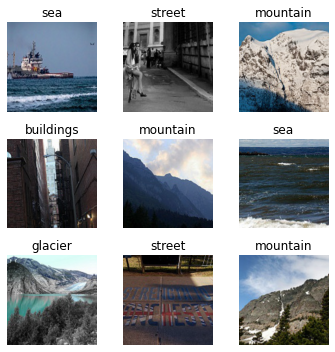

In [0]:
data.show_batch(rows=3, figsize=(5,5))

Following code block downloads the pre trained Resnet34 model which is a famous deep learning architecture already trained on large data sets. Hence, our model will not have to be trained completely new. This concept is called transfer learning, and this results in better spped and accuracy.

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)


Following code block would run our model 4 times (Epochs) over the same data set, and then save the model.

In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,0.487283,0.288939,0.896667,01:46
1,0.352374,0.246531,0.906000,01:43
2,0.291525,0.198097,0.923667,01:41
3,0.248704,0.197383,0.926667,01:39


Now, we save the model, and then will interpret the losses. 

In [0]:
learn.save('stage-1')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

Following code would plot the top losses in the model 

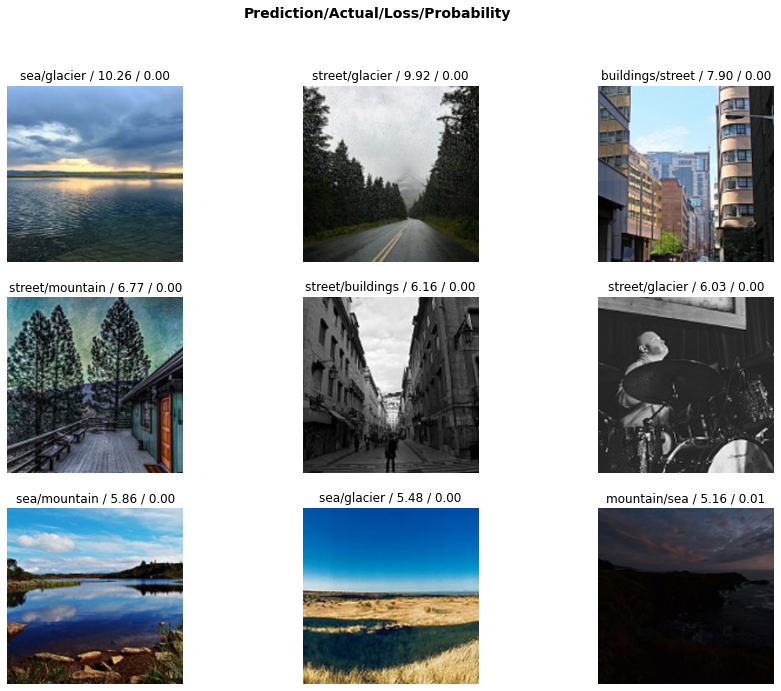

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

Again, another visualisation to see the losses.

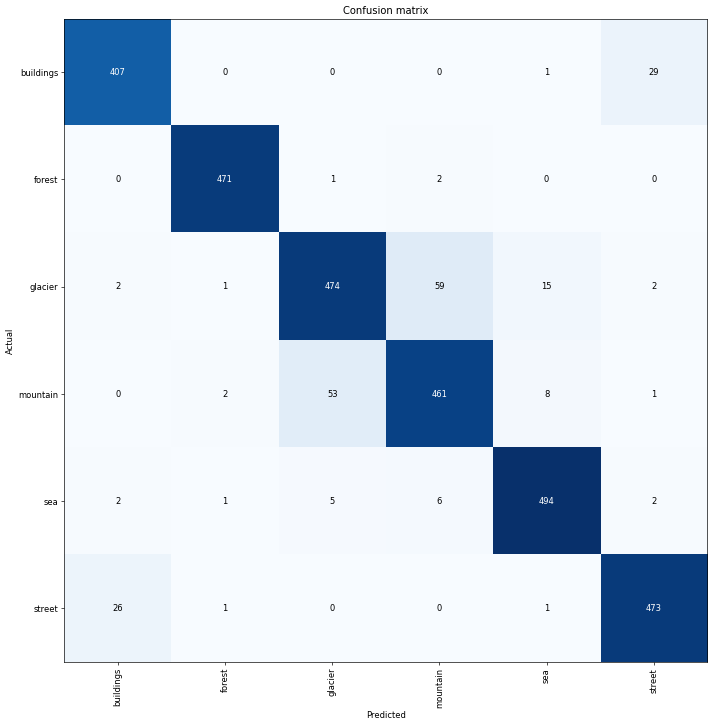

In [0]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

Again, another visualisation to see the losses.

In [0]:
interp.most_confused(min_val=2)

[('glacier', 'mountain', 59),
 ('mountain', 'glacier', 53),
 ('buildings', 'street', 29),
 ('street', 'buildings', 26),
 ('glacier', 'sea', 15),
 ('mountain', 'sea', 8),
 ('sea', 'mountain', 6),
 ('sea', 'glacier', 5),
 ('forest', 'mountain', 2),
 ('glacier', 'buildings', 2),
 ('glacier', 'street', 2),
 ('mountain', 'forest', 2),
 ('sea', 'buildings', 2),
 ('sea', 'street', 2)]

Now, we will unfreeze the model so that the pre trained weights of Resnet50 is removed. We will train it from scratch

In [0]:
learn.unfreeze()

We run it for 1 cycle, and then load the previous model again. 

In [0]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.276058,0.196270,0.928333,01:40


In [0]:
learn.load('stage-1');

Now, we see the loss vs learning rate plot. We observe that the best learning rate with lowest loss typically happens between 10^-6 to 10^-4

In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


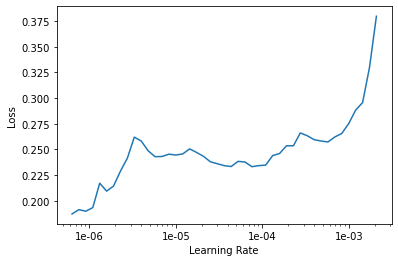

In [0]:
learn.recorder.plot()

Now, we train our model with the new learning rates. 

In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(((3e-5)-(3e-6))/2,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.150768,0.181516,0.931000,01:43
1,0.128339,0.167467,0.942000,01:41


We save the model again, and export it to use it for prediction.

In [0]:
learn.save('stage-2')

In [0]:
learn.export()

In [0]:
defaults.device = torch.device('cpu')

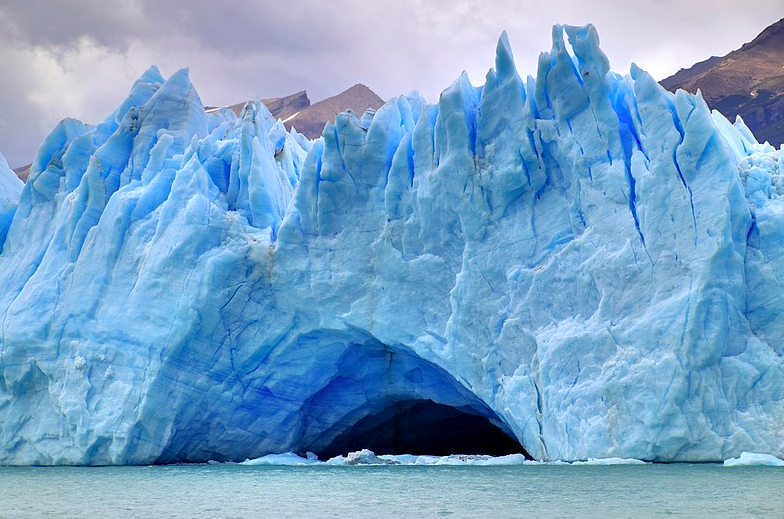

In [0]:
path_test=path/'testimage.png'
img = open_image(path_test)
img

In [0]:
learn = load_learner(path)

In [0]:
pred_class,pred_idx,outputs = learn.predict(img)
str(pred_class)


'glacier'